In [1]:
import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers
import time
from tensorflow.keras import models
from tqdm import tqdm

2.15.0


In [2]:
def plot_distribution(real_data,generated_data,discriminator=None,density=True):

    plt.hist(real_data.numpy(), 100, density=density, facecolor='g', alpha=0.75, label='real data')
    plt.hist(generated_data.numpy(), 100, density=density, facecolor='r', alpha=0.75,label='generated data q(z) ')

    if discriminator:
        max_=np.max([int(real_data.numpy().max()),int(generated_data.numpy().max())])
        min_=np.min([int(real_data.numpy().min()),int(generated_data.numpy().min())])
        x=np.linspace(min_, max_, 1000).reshape(-1,1)
        plt.plot(x,tf.math.sigmoid(discriminator(x,training=False).numpy()),label='discriminator',color='k')
        plt.plot(x,0.5*np.ones(x.shape),label='0.5',color='b')
        plt.xlabel('x')

    plt.legend()
    plt.show()

In [3]:
mean = [10]
cov = [[1]]
X = tf.random.normal((5000,1),mean=10,stddev=1.0)

print("mean:",np.mean(X))
print("standard deviation:",np.std(X))

mean: 9.983576
standard deviation: 0.99214965


In [4]:
Z = tf.random.normal((5000,1),mean=0,stddev=2)

In [5]:
print("mean:",np.mean(Z))
print("standard deviation:",np.std(Z))

mean: -0.019241776
standard deviation: 2.0383646


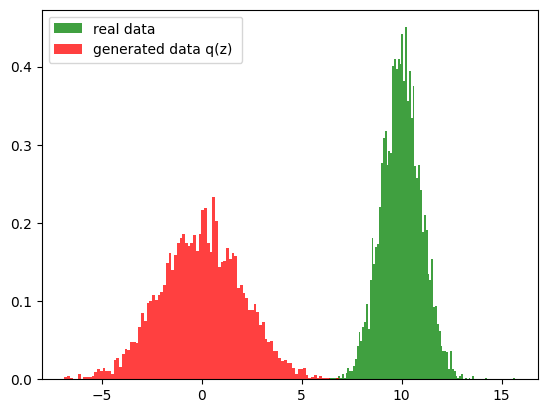

In [6]:
plot_distribution(X,Z,discriminator=None,density=True)

In [7]:
Xhat=Z+10

In [8]:
print("mean:",np.mean(Xhat))
print("standard deviation:",np.std(Xhat))

mean: 9.980759
standard deviation: 2.0383646


## The Generator
There are two networks involved in a GAN, the Generator and the Discriminator. Let's understand the Generator network first.

The Generator is a neural network denoted by $G$; the idea is that a neural network can approximate any function (by the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)), so you should be able to generate data samples from any type of distribution.

Our goal is to convert the samples, $\mathbf{z}$, to one that approximates $\hat{\mathbf{x}}$,  i.e $\hat{\mathbf{x}}=G(\mathbf{z})$. Let's build a simple Generator $G(\mathbf{z})=\mathbf{W}^{T}\mathbf{z}+\mathbf{b} $ using Keras.

The following is a function that outputs a generator using Kera's Sequential model object.


In [9]:
def make_generator_model():
  generator = tf.keras.Sequential()
  generator.add(layers.Dense(1))
  return generator

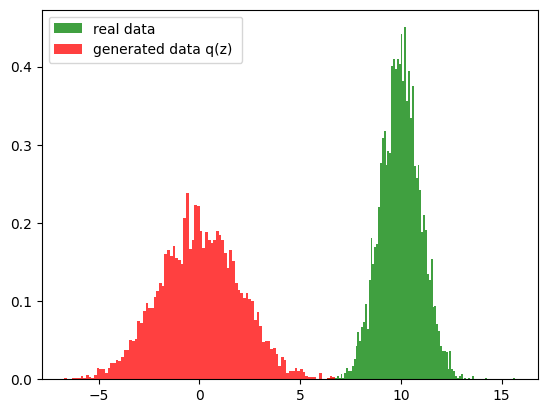

In [10]:
generator = make_generator_model()
xhat = generator(Z, training=False)
plot_distribution(real_data=X, generated_data=xhat)

## The Discriminator


In [11]:
def make_discriminator_model():
    discriminator=tf.keras.Sequential()
    discriminator.add(layers.Dense(1))
    return discriminator

discriminator=make_discriminator_model()

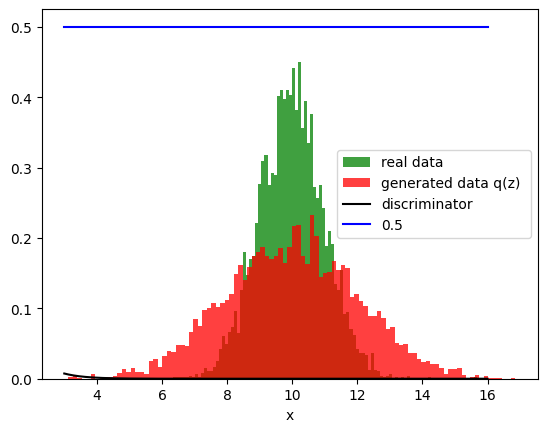

In [12]:
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator)

In [13]:
py_x=tf.math.sigmoid(discriminator(X,training=False))
np.sum(py_x>0.5)

0

In [14]:
py_x=discriminator(Xhat)
np.sum(py_x>0.5)

0

In [15]:
def get_accuracy(X,Xhat):
    total=0
    py_x=tf.math.sigmoid(discriminator(X,training=False))
    total=np.mean(py_x)
    py_x=tf.math.sigmoid(discriminator(Xhat,training=False))
    total+=np.mean(py_x)
    return total/2

In [16]:
get_accuracy(X, xhat)

0.24857889115810394

## Training GANS

### Training Generator

GANs are quite difficult to train, even for a simple example. Let's start off with training the generator in practice.

$log(1 − D(G(\mathbf{z})))$ is difficult to work with as $D(G(\mathbf{z}))$ is near one or zero for the first few iterations. This is because the generator is not yet properly trained, and the discriminator can easily distinguish between the generated and actual samples. Therefore we maximize $log(D(G(\mathbf{z}\_k)) )$.

Although the output of the generator passes through the discriminator, we do not update the generator in the optimization step, hence we set the parameter `training=False` in the actual training steps.

Instead of maximizing the term, we can take the negative and minimize it. The resultant expression can be calculated in Keras using the cross-entropy loss where all the target values are set to one:

$$\sum\_{k 	\notin \mathcal{D}} log(1 - D(G(\mathbf{z}\_k)) )$$


In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

In [18]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5,beta_2=0.8)

discriminator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5, beta_2=0.8)


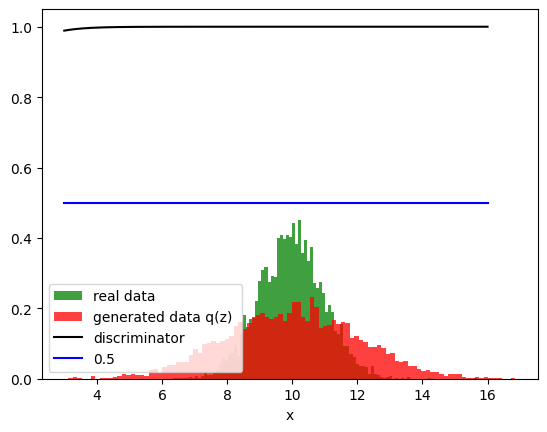

epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


0.7406460046768188


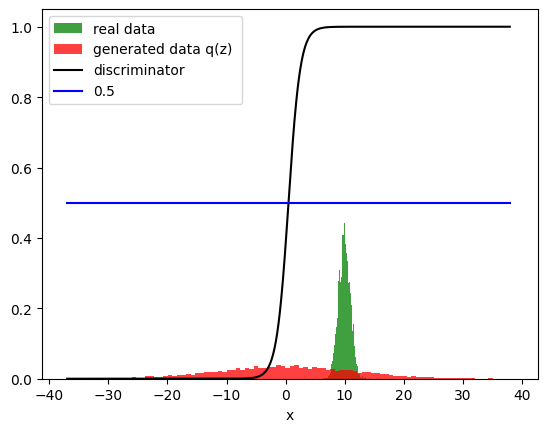

  5%|▌         | 1/20 [00:01<00:36,  1.94s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 0


0.704802930355072


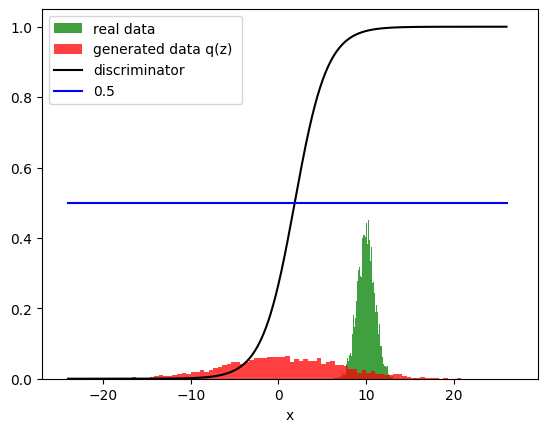

 10%|█         | 2/20 [00:02<00:25,  1.41s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 1


0.4533606171607971


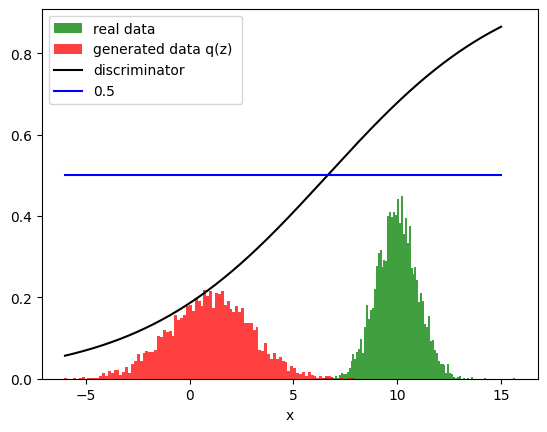

 15%|█▌        | 3/20 [00:03<00:20,  1.23s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 2


0.5329057574272156


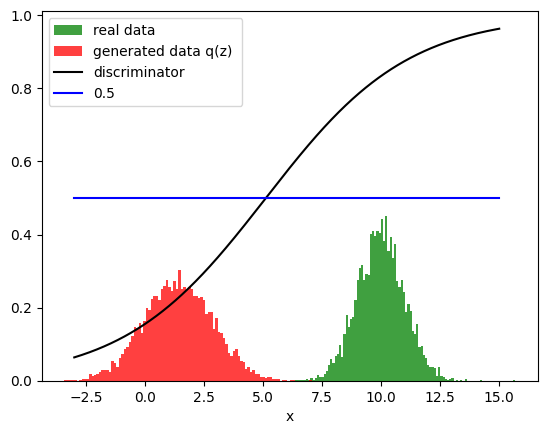

 20%|██        | 4/20 [00:05<00:18,  1.15s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 3


0.5289243459701538


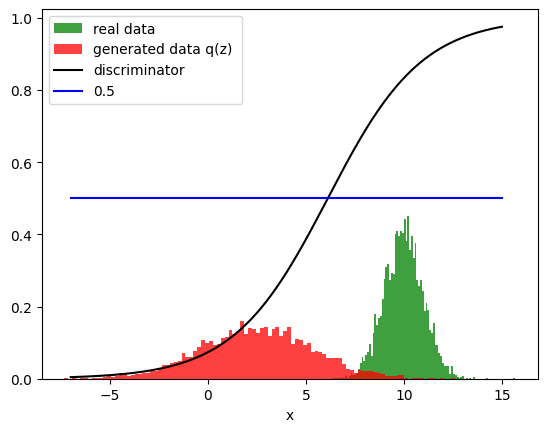

 45%|████▌     | 9/20 [00:06<00:04,  2.26it/s]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 6


0.4808428883552551


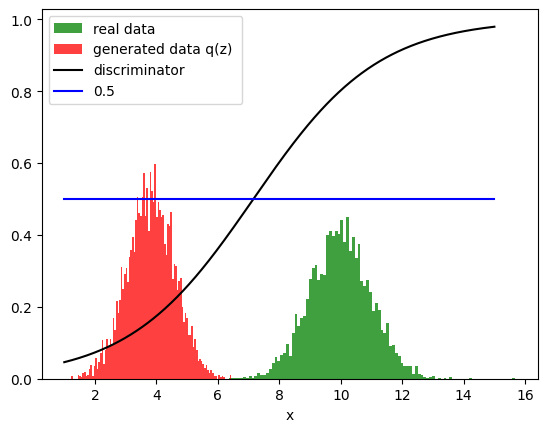

 55%|█████▌    | 11/20 [00:08<00:05,  1.55it/s]

epoch 9


100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


In [20]:
#paramters for trainng
epochs=20
BATCH_SIZE=5000
noise_dim=1
epsilon=100


#discrimator and gernerator
tf.random.set_seed(0)
discriminator=make_discriminator_model()
generator=make_generator_model()

tf.config.run_functions_eagerly(True)



gen_loss_epoch=[]
disc_loss_epoch=[]
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator )
print("epoch",0)

for epoch in tqdm(range(epochs)):
    #data for the true distribution of your real data samples training ste
    x = tf.random.normal((BATCH_SIZE,1),mean=10,stddev=1.0)
    #random samples it was found if you increase the  stander deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, noise_dim],mean=0,stddev=10)
    # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(x, training=True)
        #the output of the discriminator  data
        fake_output = discriminator(xhat, training=True)
        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # Compute the gradients for gen_loss and generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # Save and display the generator and discriminator if the performance increases
    if abs(0.5-get_accuracy(x,xhat))<epsilon:
        epsilon=abs(0.5-get_accuracy(x,xhat))
        generator.save('generator')
        discriminator.save('discriminator')
        print(get_accuracy(x,xhat))
        plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )
        print("epoch",epoch)

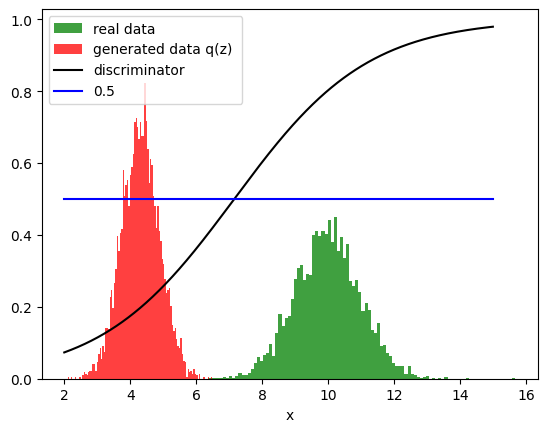

In [21]:
generator=make_generator_model()
generator= models.load_model('generator')
xhat=generator(z)
discriminator=models.load_model('discriminator')
plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )